[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/jolin-io/KI2022-tutorial-universal-differential-equations/main?filepath=02%20introduction%20to%20deep%20learning%20in%20julia.ipynb)

<a href="https://www.jolin.io" target="_blank" rel="noreferrer noopener">
<img src="https://www.jolin.io/assets/Jolin/Jolin-Banner-Website-v1.1-darkmode.webp">
</a>

# Introduction to deep learning in <img height="60px" style='height:60px;display:inline;' alt="Julia" src="https://julialang.org/assets/infra/logo.svg">

There are three well-known deep-learning packages for julia, all written in pure julia:
- [Knet.jl](https://github.com/denizyuret/Knet.jl)
- [Flux.jl](https://github.com/FluxML/Flux.jl)
- [Lux.jl](https://github.com/avik-pal/Lux.jl)

We use Lux. It was created as a more functional alternative to Flux.jl in order to address problems with the implicit parameter handling of its interface. One main application of Lux is the combination with Differential Equations, which we will see the next notebook.

Our goal of this notebook is to introduce Lux with the example of fitting a polynomial.

In [2]:
import Lux
import NNlib, Optimisers, Plots, Random, Statistics, Zygote

# Let's fit a polynomial

Generate 128 datapoints from the polynomial $y = x² - 2x$.

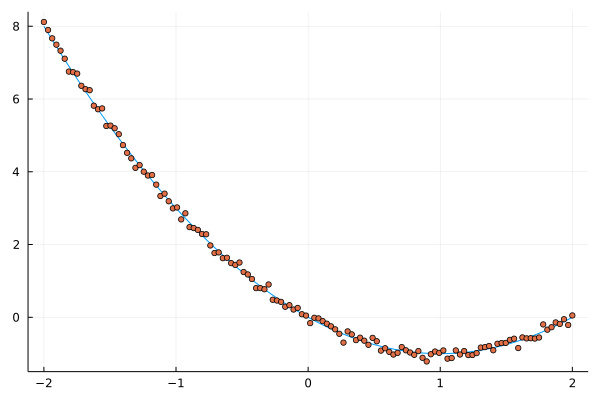

┌ Info: Precompiling GR_jll [d2c73de3-f751-5644-a686-071e5b155ba9]
└ @ Base loading.jl:1423


In [3]:
function generate_data(rng::Random.AbstractRNG)
    x = reshape(collect(range(-2.0f0, 2.0f0, 128)), (1, 128))
    y = evalpoly.(x, ((0, -2, 1),)) .+ randn(rng, (1, 128)) .* 0.1f0
    return (x, y)
end

rng = Random.MersenneTwister()
Random.seed!(rng, 12345)

(x, y) = generate_data(rng)

Plots.plot(x -> evalpoly(x, (0, -2, 1)), x[1, :]; label=false)
Plots.scatter!(x[1, :], y[1, :]; label=false, markersize=3)

In [4]:
model = Lux.Chain(
    Lux.Dense(1, 16, NNlib.relu),
    Lux.Dense(16, 1),
)

Chain(
    layer_1 = Dense(1 => 16, relu),     # 32 parameters
    layer_2 = Dense(16 => 1),           # 17 parameters
)         # Total: 49 parameters,
          #        plus 0 states, summarysize 32 bytes.

## Lux barebones

In [5]:
ps, st = Lux.setup(rng, model)

((layer_1 = (weight = Float32[0.36222202; 0.23371002; … ; 0.5260752; -0.07562564;;], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = Float32[-0.14330137 -0.39328107 … -0.34761065 -0.05758927], bias = Float32[0.0;;])), (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

In [6]:
y′, st = Lux.apply(model, x, ps, st)

(Float32[-0.29004076 -0.28547332 … -0.19033183 -0.19337715], (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

In [7]:
"""
The function must take 4 inputs – model, parameters, states and data.
The function must return 3 values – loss, updated_state, and any computed statistics.

See https://lux.csail.mit.edu/dev/api/contrib/#Lux.Training.compute_gradients
"""
function loss_function(model, ps, st, data)
    x, y = data
    y_pred, st = Lux.apply(model, x, ps, st)
    loss = Statistics.mean(abs2, y_pred .- y)
    statistics = ()
    return loss, st, ()
end

loss_function

In [67]:
loss_function(model, ps, st, (x, y))

(9.437287494641955, (layer_1 = NamedTuple(), layer_2 = NamedTuple()), ())

Now, you can combine these with your automatic differentiation package of choice.
However, be cautious. Because Lux uses nested NamedTuples for parameters `ps` and states `st`, it might be that your particular autodiff package does not yet support it out-of-the-box.

To simplify everything, Lux comes with a unified training interface, which takes care of this.

## Lux extra training helpers

Lux.Training comes with `TrainState` and `compute_gradients` in order to simplify interacting with different AutoDifferentiation backends.

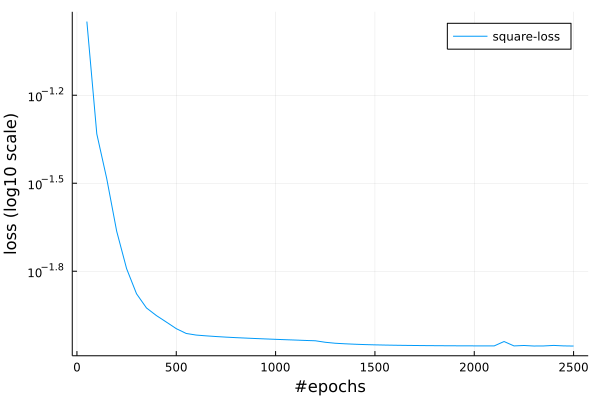

In [22]:
# There is also EnzymeVJP which might lead better compatibility and performance
ad_backend = Lux.Training.ZygoteVJP()
opt = Optimisers.Adam(0.03)
trainstate = Lux.Training.TrainState(rng, model, opt)
data = (x, y)
n_epochs = 2500

losses = Float64[]
epochs = Int[]

for epoch in 1:n_epochs
    grads, loss, statistics, trainstate = Lux.Training.compute_gradients(
        ad_backend, loss_function, data, trainstate)

    if epoch % 50 == 0
        push!(losses, loss)
        push!(epochs, epoch)
        Plots.plot(epochs, losses, show = :inline, yscale = :log10,
            label = "loss", xlabel = "#epochs", ylabel="loss (log10 scale)")
    end

    trainstate = Lux.Training.apply_gradients(trainstate, grads)
end

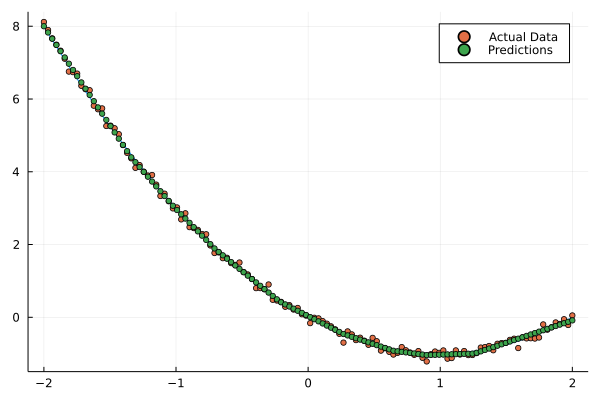

In [20]:
y_pred, st_pred = Lux.apply(trainstate.model, x, trainstate.parameters, trainstate.states)

Plots.plot(x -> evalpoly(x, (0, -2, 1)), x[1, :]; label=false)
Plots.scatter!(x[1, :], y[1, :]; label="Actual Data", markersize=3)
Plots.scatter!(x[1, :], y_pred[1, :]; label="Predictions", markersize=3)

# That was the introduction to deep learning in julia - Thank you for participating 🙂

Next topic is Universal Differential Equations, i.e. one way to combine deep learning methods with differential equations: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/jolin-io/KI2022-tutorial-universal-differential-equations/main?filepath=03%20introduction%20to%20neural%20differential%20equations.ipynb)